This is playing with pytorch framework for EHR modeling. In general, a patient's health record can be represented as a sequence of visits. Each visit has certain features, and can be represented as a list of medical codes.

For simplicity, we are starting with the data structure that a patient's health record is a list of list, following the line of work from Jimeng Sun's lab. We will use codes from Ed Choi to manipulate the data. 

* This notebook is to present how our logistic regression model works on the cerner sample data for predicting readmission using pytorch library.
* The logistic regression model has the architecture of an embedding layer, a linear activation and sigmoid transformation.
* Our model currently achieves around 0.81 test accuracy.
* Visualization of training loss, training auc, validation auc, and test auc for each epoch as well as how average loss, training auc, validation auc and test auc change with epochs are shown at the end.

In [1]:
from __future__ import print_function, division
from io import open
import string
import re
import random
import pandas as pd
import os
import sys
import argparse
import time
import math

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
from torchviz import make_dot, make_dot_from_trace

from sklearn.metrics import roc_auc_score  
from sklearn.metrics import roc_curve 

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

try:
    import cPickle as pickle
except:
    import pickle
    
import operator
from functools import reduce     

In [2]:
# import self-defined modules
# import ehr_pytorch.model as model 
# import ehr.pytorch.Loaddata as Loaddata
# import ehr.pytorch.TrainVeTe as TVT 

import model_lr1 as model #here the em experiment
import Loaddata as Loaddata
import TrainVaTe_lr1 as TVT

# check GPU availability
use_cuda = torch.cuda.is_available()
use_cuda

True

In [3]:
parser = argparse.ArgumentParser(description='30 Hospital Readmission Model with Pytorch: LR, RNN, CNN')
# learning
parser.add_argument('-lr', type=float, default=np.exp(-7.8810), help='initial learning rate [default: 0.0004]')
parser.add_argument('-L2', type=float, default=np.exp(-5.8401), help='L2 regularization [default: 0.003]')
parser.add_argument('-epochs', type=int, default=20, help='number of epochs for train [default: 20]')
parser.add_argument('-batch_size', type=int, default=1, help='batch size for training [default: 1]')
#parser.add_argument('-save-dir', type=str, default='snapshot', help='where to save the snapshot')
#parser.add_argument('-save-best', type=bool, default=True, help='whether to save when get best performance')
# data 
parser.add_argument('-seq_file', type = str, default = 'data/cerner/hospital_data/h143.visits' , help='the path to the Pickled file containing visit information of patients')
parser.add_argument('-label_file', type = str, default = 'data/cerner/hospital_data/h143.labels', help='the path to the Pickled file containing label information of patients')
parser.add_argument('-validation_ratio', type = float, default = 0.1, help='validation data size [default: 0.1]')
parser.add_argument('-test_ratio', type = float, default = 0.2, help='test data size [default: 0.2]')
# model
parser.add_argument('-which_model', type = str, default = 'LR', help='choose from {"LR", "RNN", "CNN"}')
parser.add_argument('-input_size', type = int, default =20000, help='input dimension [default: 20000]')
parser.add_argument('-embed_dim', type=int, default=1, help='number of embedding dimension [default: 1]')
parser.add_argument('-ch_out', type=int, default=64, help='number of each kind of kernel [default; 64]')
parser.add_argument('-kernel_sizes', type=list, default=[3], help='comma-separated kernel size to use for convolution [default:[3]')
parser.add_argument('-dropout', type=float, default=0.1, help='the probability for dropout [default: 0.1]')
parser.add_argument('-eb_mode', type=str, default='sum', help= "embedding mode [default: 'sum']")

_StoreAction(option_strings=['-eb_mode'], dest='eb_mode', nargs=None, const=None, default='sum', type=<class 'str'>, choices=None, help="embedding mode [default: 'sum']", metavar=None)

In [4]:
# a block to simulate args reading from command line 
args = parser.parse_args(args=[])
args.lr = np.exp(-8.4004)
args.L2 = np.exp(-6.1833)
args.epochs = 20
args.batch_size = 1
#args.seq_file = 'data/cerner/hospital_data/h143.visits'
#args.label_file = 'data/cerner/hospital_data/h143.labels'
#args.seq_file = 'Data/h143.visits'
#args.label_file = 'Data/h143.labels'
args.which_model = 'LR'
args.input_size = 20000

In [5]:
def data_load_split_VT(folder = 'data2/cerner/hospital_data/', hosp_list=[143,104,118], test_r=0.2 , valid_r=0.1):

   merged_set=[]
   for h in hosp_list:
       seqFile= folder+'h'+str(h)+'.visits'
       labelFile= folder+'h'+str(h)+'.labels'
       set_x = pickle.load(open(seqFile, 'rb'), encoding='bytes')
       set_y = pickle.load(open(labelFile, 'rb'),encoding='bytes')
       merged_set_h = [[set_y[i],set_x[i]] for i in range(len(set_x))] # merge the two lists
       #merged_set_h_f = [[set_y[i],set_x[i][:-1]] for i in range(len(set_x))] # added [:-1] to exclude last visit
       #merged_set_h =[x for x in merged_set_f if len(x[1])>0]

       merged_set.extend(merged_set_h)

   #print (set_y[1],set_x[1][:-1], len(set_x[1][:-1]))

   # set random seed
   random.seed( 3 )

   dataSize = len(merged_set)
   nTest = int(test_r * dataSize)
   nValid = int(valid_r * dataSize)

   random.shuffle(merged_set)

   test_set = merged_set[:nTest]
   valid_set = merged_set[nTest:nTest+nValid]
   train_set = merged_set[nTest+nValid:]

   return train_set, valid_set, test_set

In [6]:
train1 , valid1, test1 = data_load_split_VT()
test_sh_L =[x for x in test1 if len(x[1])< 5]
test_l_L = [x for x in test1 if x not in test_sh_L]
print (len(train1),len(valid1),len(test1))

101567 14509 29019


In [7]:
# load and prepare data
#set_x = pickle.load(open(args.seq_file, 'rb'), encoding='bytes')
#set_y = pickle.load(open(args.label_file, 'rb'),encoding='bytes')

#preprocessing
# LR needs to have input format of list; list of list for NN models
"""
if args.which_model == 'LR':
    model_x = []
    for patient in set_x:
        model_x.append([each for visit in patient for each in visit]) 
"""
#model_x = set_x     

#merged_set= [[set_y[i],model_x[i]] for i in range(len(set_y))] #list of list or list of lists of lists
print("\nLoading and preparing data...")    
#train1, valid1, test1 = Loaddata.load_data(merged_set)
print("\nSample data after split:")  
print(train1[0])
print("model is", args.which_model)

#further processing training, valid, test data format, for the visits information merged into one huge list 

#split the test data according to length
#test_sh_L =[x for x in test1 if len(x[1])< 5]
#test_l_L = [x for x in test1 if x not in test_sh_L]
#print(test_sh_L[0])
#print(test_l_L[0])

train1 = [[train1[i][0],reduce(operator.concat, train1[i][1])] for i in range(len(train1))]
valid1 = [[valid1[i][0],reduce(operator.concat, valid1[i][1])] for i in range(len(valid1))]
test1 = [[test1[i][0],reduce(operator.concat, test1[i][1])] for i in range(len(test1))]
test_sh_L = [[test_sh_L[i][0],reduce(operator.concat, test_sh_L[i][1])] for i in range(len(test_sh_L))]
test_l_L = [[test_l_L[i][0],reduce(operator.concat, test_l_L[i][1])] for i in range(len(test_l_L))]
print('-' * 120)
print('\nAfter flatten:')
print(train1[4])
print(test_sh_L[0])
print(test_l_L[0])


Loading and preparing data...

Sample data after split:
[0, [[195, 182, 305], [156, 3067, 22, 203, 23, 1259, 262, 883, 761, 956, 857, 102, 1782, 283, 2453], [212, 140], [12, 156, 88, 212, 157, 161, 22, 23, 1259, 135, 167, 429, 855, 224, 31, 857, 282, 1782, 10, 2453, 1035]]]
model is LR
------------------------------------------------------------------------------------------------------------------------

After flatten:
[0, [1250, 345, 84, 85, 1747, 5619, 345, 84, 85, 5619, 2898, 1, 307, 6, 79, 8, 44, 345, 84, 85, 622, 1677, 1453, 250, 345, 84, 85, 5318, 144, 84, 85, 1250, 144, 84, 85, 632, 375, 144, 84, 85, 632, 617, 1453, 144, 84, 85, 632, 1250, 144, 84, 85]]
[0, [671, 537, 149, 62, 85]]
[0, [1831, 345, 62, 85, 1831, 345, 62, 85, 1831, 345, 62, 85, 1831, 345, 62, 85, 1831, 345, 62, 85, 1831, 345, 62, 85, 1831, 345, 62, 85, 1831, 345, 62, 85, 1831, 345, 62, 85, 1831, 345, 62, 85, 1831, 345, 62, 85]]


In [8]:
# model loading part
if args.which_model == 'LR': 
    ehr_model = model.EHR_LR(args.input_size, embed_dim =1)
elif args.which_model == 'RNN':
    ehr_model = model.EHR_RNN(args.input_size, args.embed_dim, args.dropout, args.eb_mode) 
else: 
    ehr_model = model.EHR_CNN(args.input_size, args.embed_dim, args.dropout, args.eb_mode, args.ch_out, args.kernel_sizes)    
if use_cuda:
    ehr_model = ehr_model.cuda()

optimizer = optim.Adam(ehr_model.parameters(), lr=args.lr, weight_decay=args.L2)

Parameter containing:
 1.0318e+00
 1.0578e+00
-8.4609e-01
     ⋮      
 3.2322e-01
 2.2294e-01
-1.3975e+00
[torch.FloatTensor of size 20000x1]

        emb                           types
0  1.031836                            Code
1  1.057760  b'M_ACETAMINOPHEN-HYDROCODONE'
2 -0.846087         b'M_BACITRACIN TOPICAL'
3 -1.626085    b'M_BUPIVACAINE-EPINEPHRINE'
4  1.008338                  b'M_CEFAZOLIN'


In [9]:
## train validation and test part
current_loss_allep=[]
all_losses_allep=[]
avg_losses_allep=[]
train_auc_allep =[]
valid_auc_allep =[]
test_auc_allep=[]
test_sh_auc_allep=[]
test_l_auc_allep=[]

In [10]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


 Current running on: Epoch  0 Training loss:  Average loss 0.5276831689875414


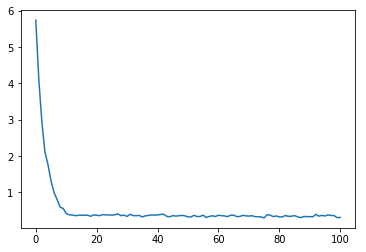

Epoch  0 Summary:  Training_auc : 0.7118800750528715  , Validation_auc :  0.7029723815102491  ,Test_auc :  0.7095125811284057 Test_auc on short visits: 0.7082064551702498 Test_auc on long visits: 0.7202089672799302  Avg Loss:  0.5276831689875414 Train Time (2m 50s) Eval Time (1m 32s)

 Current running on: Epoch  1 Training loss:  Average loss 0.33768026335113627


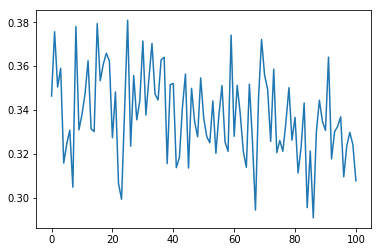

Epoch  1 Summary:  Training_auc : 0.7592225781111548  , Validation_auc :  0.7511965181122141  ,Test_auc :  0.7544350473583197 Test_auc on short visits: 0.7502093842607133 Test_auc on long visits: 0.7668768950450787  Avg Loss:  0.33768026335113627 Train Time (2m 56s) Eval Time (1m 38s)

 Current running on: Epoch  2 Training loss:  Average loss 0.3293188022218506


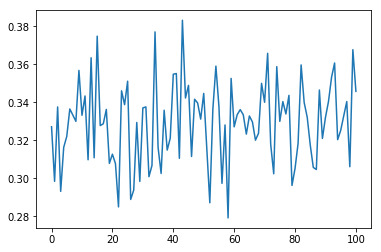

Epoch  2 Summary:  Training_auc : 0.7733197018059759  , Validation_auc :  0.7652495994527354  ,Test_auc :  0.7674833603935419 Test_auc on short visits: 0.760790557593949 Test_auc on long visits: 0.780312159924682  Avg Loss:  0.3293188022218506 Train Time (3m 3s) Eval Time (1m 43s)

 Current running on: Epoch  3 Training loss:  Average loss 0.32741956124205046


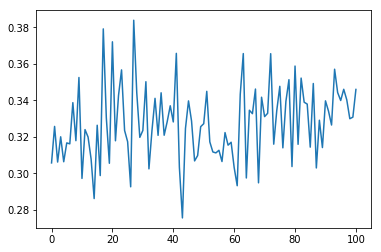

Epoch  3 Summary:  Training_auc : 0.7715309332441149  , Validation_auc :  0.7607651549036633  ,Test_auc :  0.766326362308325 Test_auc on short visits: 0.761558827667902 Test_auc on long visits: 0.7777272341827266  Avg Loss:  0.32741956124205046 Train Time (3m 12s) Eval Time (1m 59s)

 Current running on: Epoch  4 Training loss:  Average loss 0.32710510799176706


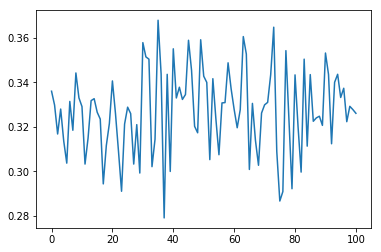

Epoch  4 Summary:  Training_auc : 0.7665951387680778  , Validation_auc :  0.7570414155024139  ,Test_auc :  0.7610792320607911 Test_auc on short visits: 0.7617127182319667 Test_auc on long visits: 0.7712939196571552  Avg Loss:  0.32710510799176706 Train Time (2m 45s) Eval Time (1m 18s)

 Current running on: Epoch  5 Training loss:  Average loss 0.326959868840283


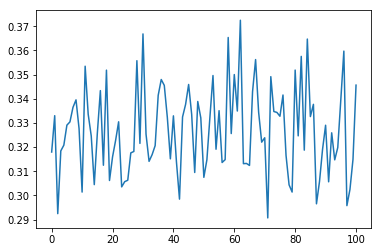

Epoch  5 Summary:  Training_auc : 0.7716480800667092  , Validation_auc :  0.7614439965454385  ,Test_auc :  0.7648520158220191 Test_auc on short visits: 0.7572988041594824 Test_auc on long visits: 0.7787845184941179  Avg Loss:  0.326959868840283 Train Time (2m 45s) Eval Time (1m 24s)

 Current running on: Epoch  6 Training loss:  Average loss 0.32624258211578794


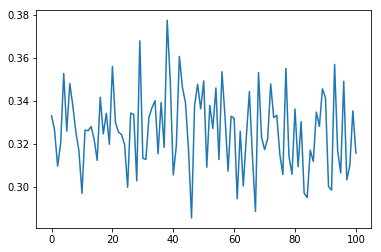

Epoch  6 Summary:  Training_auc : 0.7755642476385496  , Validation_auc :  0.7666028283645163  ,Test_auc :  0.7688011920688292 Test_auc on short visits: 0.7602450825984282 Test_auc on long visits: 0.7825752065864129  Avg Loss:  0.32624258211578794 Train Time (2m 18s) Eval Time (1m 58s)

 Current running on: Epoch  7 Training loss:  Average loss 0.32677367050046285


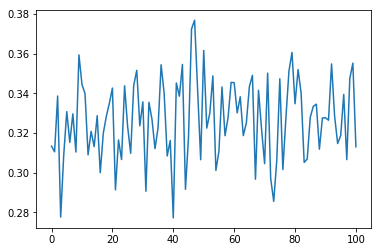

Epoch  7 Summary:  Training_auc : 0.7761677084953782  , Validation_auc :  0.7655752071052075  ,Test_auc :  0.7673706938921896 Test_auc on short visits: 0.7601433091808893 Test_auc on long visits: 0.7803424099809422  Avg Loss:  0.32677367050046285 Train Time (2m 25s) Eval Time (1m 22s)

 Current running on: Epoch  8 Training loss:  Average loss 0.3267946044865301


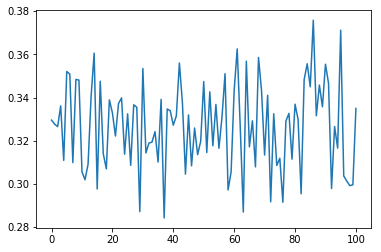

Epoch  8 Summary:  Training_auc : 0.7710544842054676  , Validation_auc :  0.7583978986443477  ,Test_auc :  0.7660411591724916 Test_auc on short visits: 0.7601189674975194 Test_auc on long visits: 0.7791524113616276  Avg Loss:  0.3267946044865301 Train Time (2m 27s) Eval Time (1m 18s)

 Current running on: Epoch  9 Training loss:  Average loss 0.3269891053412905


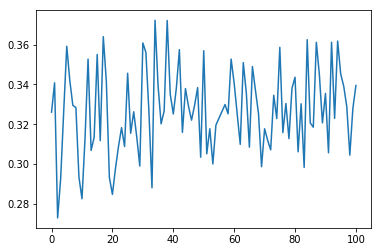

Epoch  9 Summary:  Training_auc : 0.7717041227429177  , Validation_auc :  0.7612955713389564  ,Test_auc :  0.76545016954341 Test_auc on short visits: 0.7577470650339577 Test_auc on long visits: 0.7802663907470162  Avg Loss:  0.3269891053412905 Train Time (2m 32s) Eval Time (1m 18s)

 Current running on: Epoch  10 Training loss:  Average loss 0.32649191067449684


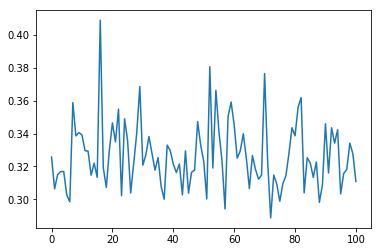

Epoch  10 Summary:  Training_auc : 0.7743598682582171  , Validation_auc :  0.7628071958644966  ,Test_auc :  0.7680329857165953 Test_auc on short visits: 0.7586875773172749 Test_auc on long visits: 0.782786984159081  Avg Loss:  0.32649191067449684 Train Time (2m 30s) Eval Time (1m 20s)

 Current running on: Epoch  11 Training loss:  Average loss 0.32726094664643496


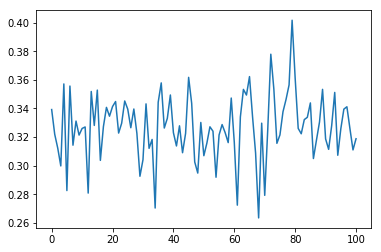

Epoch  11 Summary:  Training_auc : 0.7736484691142251  , Validation_auc :  0.7651304392379839  ,Test_auc :  0.7677819884399438 Test_auc on short visits: 0.7633313638698607 Test_auc on long visits: 0.7792493854862784  Avg Loss:  0.32726094664643496 Train Time (2m 59s) Eval Time (1m 18s)

 Current running on: Epoch  12 Training loss:  Average loss 0.32645256996090066


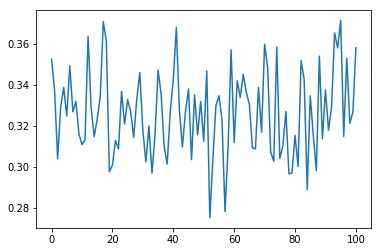

Epoch  12 Summary:  Training_auc : 0.7699624337405073  , Validation_auc :  0.7624930126370295  ,Test_auc :  0.7655354837774352 Test_auc on short visits: 0.7602367842972793 Test_auc on long visits: 0.7768263641334894  Avg Loss:  0.32645256996090066 Train Time (2m 34s) Eval Time (1m 18s)

 Current running on: Epoch  13 Training loss:  Average loss 0.3262251581768781


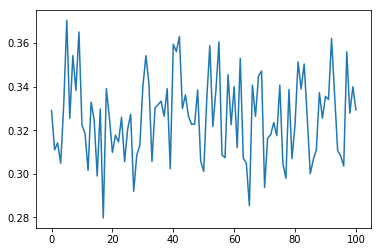

Epoch  13 Summary:  Training_auc : 0.7745055425659333  , Validation_auc :  0.7657296099401267  ,Test_auc :  0.7669063658667731 Test_auc on short visits: 0.7632893763737026 Test_auc on long visits: 0.7775355145988457  Avg Loss:  0.3262251581768781 Train Time (2m 27s) Eval Time (1m 18s)

 Current running on: Epoch  14 Training loss:  Average loss 0.327027496923164


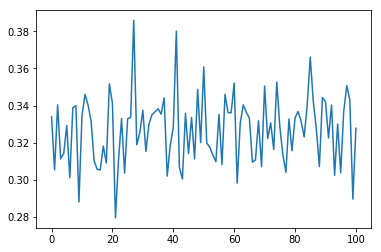

Epoch  14 Summary:  Training_auc : 0.7703658125007535  , Validation_auc :  0.7599101463203428  ,Test_auc :  0.7624627091776641 Test_auc on short visits: 0.7575535715430308 Test_auc on long visits: 0.7754371717474803  Avg Loss:  0.327027496923164 Train Time (3m 7s) Eval Time (1m 18s)

 Current running on: Epoch  15 Training loss:  Average loss 0.32685329243638306


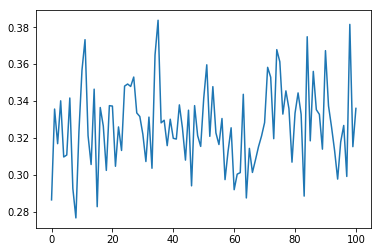

Epoch  15 Summary:  Training_auc : 0.7749295170096862  , Validation_auc :  0.7648331041524438  ,Test_auc :  0.7675712150858327 Test_auc on short visits: 0.7625137999794278 Test_auc on long visits: 0.779875912257986  Avg Loss:  0.32685329243638306 Train Time (2m 31s) Eval Time (1m 19s)

 Current running on: Epoch  16 Training loss:  Average loss 0.3266285990319705


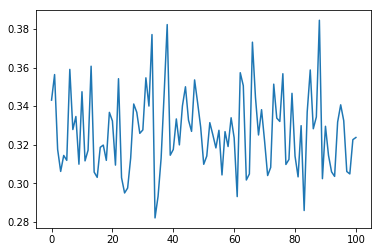

Epoch  16 Summary:  Training_auc : 0.7759988878201005  , Validation_auc :  0.7663062779869563  ,Test_auc :  0.7682393894824893 Test_auc on short visits: 0.7649796735497928 Test_auc on long visits: 0.7785828786312299  Avg Loss:  0.3266285990319705 Train Time (2m 18s) Eval Time (1m 6s)

 Current running on: Epoch  17 Training loss:  Average loss 0.3268986771551886


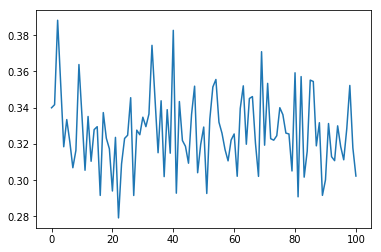

Epoch  17 Summary:  Training_auc : 0.7693090874789822  , Validation_auc :  0.7590906111536545  ,Test_auc :  0.7627893895287821 Test_auc on short visits: 0.7631798960282004 Test_auc on long visits: 0.7716008775505988  Avg Loss:  0.3268986771551886 Train Time (2m 24s) Eval Time (1m 9s)

 Current running on: Epoch  18 Training loss:  Average loss 0.327263410586275


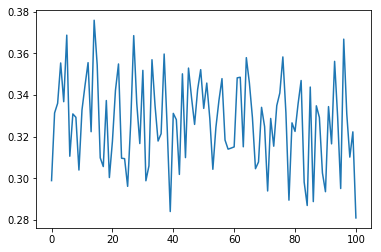

Epoch  18 Summary:  Training_auc : 0.7639778919733287  , Validation_auc :  0.7543071467048497  ,Test_auc :  0.7592797690165665 Test_auc on short visits: 0.7620269472354716 Test_auc on long visits: 0.769747905326293  Avg Loss:  0.327263410586275 Train Time (1m 58s) Eval Time (1m 6s)

 Current running on: Epoch  19 Training loss:  Average loss 0.32723702632078544


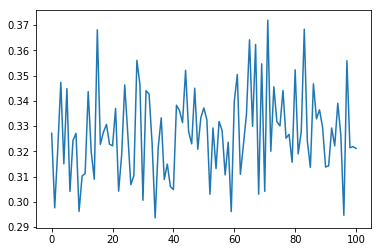

Epoch  19 Summary:  Training_auc : 0.7686480242151719  , Validation_auc :  0.7589265841061552  ,Test_auc :  0.7608267048637175 Test_auc on short visits: 0.7610813224355846 Test_auc on long visits: 0.7699118481289537  Avg Loss:  0.32723702632078544 Train Time (2m 12s) Eval Time (1m 6s)


In [11]:
# train, validation, and test for each epoch 
for ep in range(args.epochs):
    start = time.time()
    current_loss, train_loss, _ = TVT.train(train1, model= ehr_model, optimizer = optimizer, batch_size = args.batch_size) #mb=args.mb
    avg_loss = np.mean(train_loss)
    train_time = timeSince(start)
    print ('\n Current running on: Epoch ', ep,'Training loss:',' Average loss', avg_loss)
    #print(train_loss, '\n train loss plot')
    TVT.showPlot(train_loss)
    eval_start = time.time()
    train_auc, y_real, y_hat, emb = TVT.calculate_auc(model= ehr_model, data = train1, which_model = args.which_model, batch_size = args.batch_size)
    #print ('\n Current running on: Epoch ', ep,' Training auc:', train_auc)
    #TVT.auc_plot(y_real, y_hat)
    valid_auc, _, _, _  = TVT.calculate_auc(model = ehr_model, data = valid1, which_model = args.which_model, batch_size = args.batch_size)
    #print ('\n Current running on: Epoch ', ep,' validation auc:', valid_auc)
    #TVT.auc_plot(y_real, y_hat)
    test_auc, _, _, _ = TVT.calculate_auc(model = ehr_model, data = test1, which_model = args.which_model, batch_size = args.batch_size)
    shorttest_auc, _, _, _ = TVT.calculate_auc(model = ehr_model, data = test_sh_L, which_model = args.which_model, batch_size = args.batch_size)
    longtest_auc, _, _, _ = TVT.calculate_auc(model = ehr_model, data = test_l_L, which_model = args.which_model, batch_size = args.batch_size) 
    #print ('\n Current running on: Epoch ', ep,' test auc:', test_auc)
    #TVT.auc_plot(y_real, y_hat)
    eval_time = timeSince(eval_start)
    print ("Epoch ", ep, "Summary:  Training_auc :", train_auc, " , Validation_auc : ", valid_auc, " ,Test_auc : " , test_auc, 
           "Test_auc on short visits:",shorttest_auc, "Test_auc on long visits:", longtest_auc," Avg Loss: ", avg_loss, 'Train Time (%s) Eval Time (%s)'%(train_time,eval_time) )
    current_loss_allep.append(current_loss)
    all_losses_allep.append(train_loss)
    avg_losses_allep.append(avg_loss)
    train_auc_allep.append(train_auc)
    valid_auc_allep.append(valid_auc)
    test_auc_allep.append(test_auc)
    test_sh_auc_allep.append(shorttest_auc)
    test_l_auc_allep.append(longtest_auc)
    #emb_wdf = pd.DataFrame(emb.weight)
    #emb_wdf.columns = ['emb_w']
    #print(emb_wdf.head())
    #emb_wdf.to_csv('embedding weight at Epoch'+str(ep), sep='\t')
    #print(emb)
    #print(len(emb)-1)
    #print(len(y_real))
    #color1 = np.array([item for item in y_real])
    #plt.figure()
    #plt.scatter(emb[1:,0],emb[1:,1], c= color1, cmap= 'plasma', alpha = 0.5)
    #plt.title('Training Embeded on epoch '+str(ep)+' with real labels')
    #plt.show()
    #color2 = np.array([item for item in y_hat])
    #plt.scatter(emb[1:,0],emb[1:,1], c= color2, cmap='plasma', alpha = 0.5)
    #plt.title('Training Embeded on epoch '+str(ep)+' with predicted probabilites')
    #plt.show()

In [12]:
# average losses, training auc, validation auc and test auc with epochs
"""
TVT.showPlot(avg_losses_allep)
TVT.showPlot(train_auc_allep)
TVT.showPlot(valid_auc_allep)
TVT.showPlot(test_auc_allep)
"""

'\nTVT.showPlot(avg_losses_allep)\nTVT.showPlot(train_auc_allep)\nTVT.showPlot(valid_auc_allep)\nTVT.showPlot(test_auc_allep)\n'

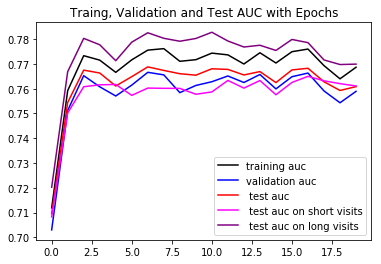

In [13]:
#plot all three auc in a same plot 
plt.plot(train_auc_allep, color= 'black', label = 'training auc')
plt.plot(valid_auc_allep, color ='blue', label = 'validation auc')
plt.plot(test_auc_allep, color = 'red', label =' test auc')
plt.plot(test_sh_auc_allep, color = 'magenta', label =' test auc on short visits')
plt.plot(test_l_auc_allep, color = 'purple', label =' test auc on long visits')
plt.title('Traing, Validation and Test AUC with Epochs' )
plt.legend(loc= 'lower right')
plt.show()

In [14]:
import plotly.plotly as py 
import plotly.graph_objs as go
py.sign_in('GinnyJZ','xJj3WJ9XiB3ijm4frOXc') #get my own sign in please

train_auc_fg= go.Scatter(x= np.arange(args.epochs), y=train_auc_allep, name ='Training auc')
valid_auc_fg= go.Scatter(x= np.arange(args.epochs), y=valid_auc_allep, name ='Validation auc')
test_auc_fg= go.Scatter(x= np.arange(args.epochs), y=test_auc_allep, name ='Test auc')
test_sh_auc_fg= go.Scatter(x= np.arange(args.epochs), y=test_sh_auc_allep, name ='Test auc on <5 visits)')
test_l_auc_fg= go.Scatter(x= np.arange(args.epochs), y=test_l_auc_allep, name ='Test auc on >=5 visits)')

valid_max = max(valid_auc_allep)
test_max = max(test_auc_allep)

data = [train_auc_fg, valid_auc_fg, test_auc_fg, test_sh_auc_fg, test_l_auc_fg]#,valid_auc_allep,test_auc_allep] 
layout = go.Layout(showlegend= True, xaxis=dict(dtick=1))
layout.update(dict(annotations=[go.Annotation(text="Max Valid", x=valid_auc_allep.index(valid_max), y=valid_max)]))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='LR_Auc_dim1_largeData')
#url = py.plot(data, filename='some-data')  # gen. online plot
#py.image.save_as(data, 'some-data.png')

In [15]:
#extract weights
torch.save(ehr_model, 'Lr1model_dim1_largeData')
z= pd.DataFrame(ehr_model.embedding.weight.cpu().data.numpy())
z.to_csv('embedding weights_dim1_largeData')
ehr_model.embedding.weight

Parameter containing:
-2.3773e-08
-1.7521e-02
-7.6150e-02
     ⋮      
 1.4793e-06
 2.7867e-06
-1.7995e-13
[torch.cuda.FloatTensor of size 20000x1 (GPU 0)]